In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import random
import time
from math import sqrt
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import (matthews_corrcoef, accuracy_score, confusion_matrix, 
                             roc_auc_score, average_precision_score, 
                             cohen_kappa_score, balanced_accuracy_score, 
                             roc_curve, auc, precision_recall_curve)
from bayes_opt import BayesianOptimization
from utils import (
    single_task, EarlyStopping, train_single_task, val_single_task, test_single_task,
    FocalLoss, load_data, CustomDataset)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset,Subset, DataLoader, Dataset as TorchDataset 
from torch_geometric.data import InMemoryDataset, DataLoader, Batch, Dataset, Data, data
from collections import defaultdict
torch.use_deterministic_algorithms(True, warn_only=True)
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, ParameterGrid
import pandas as pd
import matplotlib.pyplot as plt  
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    
  
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

    np.random.seed(seed)
    random.seed(seed)
    

set_seed(2)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
rng = np.random.default_rng(8888)
rfloat = rng.random()

In [ ]:
def evaluate_model(model, device, data_loader):
    model.eval()
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for batch in data_loader:
            data = batch.to(device)
            labels = batch.y.to(device)
            outputs, _ = model(data)
            outputs = outputs.view_as(labels)
            probs = torch.sigmoid(outputs).cpu().numpy()
            y_scores.extend(probs.flatten())
            y_true.extend(labels.cpu().numpy().flatten())
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    

    mask = y_true != -1
    y_true = y_true[mask]
    y_scores = y_scores[mask]
    
    try:
        auc = roc_auc_score(y_true, y_scores)
    except ValueError:
        auc = np.nan  

    try:
        pr_auc = average_precision_score(y_true, y_scores)
    except ValueError:
        pr_auc = np.nan 

    y_pred_labels = (y_scores >= 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    
    return auc, pr_auc, accuracy

### liv

Total hyperparameter combinations to evaluate: 12

===== Evaluating Hyperparameter Combination 1/12 =====
Parameters: {'batch_size': 8, 'dropout': 0.2, 'lr': 0.001, 'output_dim': 16, 'wd': 1e-06}

--- Fold 1/20 ---
Early stopping triggered at epoch 66. Best Val Loss: 0.0103
====> Epoch: 66 Average test Loss: 0.0162
Fold 1 Results - Best Epoch: 66, Val Loss: 0.0103, Test Loss: 0.0162, Test AUC: 0.6790, PR AUC: 0.6412, Accuracy: 0.5000

--- Fold 2/20 ---
Early stopping triggered at epoch 46. Best Val Loss: 0.0106
====> Epoch: 46 Average test Loss: 0.0160
Fold 2 Results - Best Epoch: 46, Val Loss: 0.0106, Test Loss: 0.0160, Test AUC: 0.6049, PR AUC: 0.6970, Accuracy: 0.5000

--- Fold 3/20 ---
Early stopping triggered at epoch 66. Best Val Loss: 0.0129
====> Epoch: 66 Average test Loss: 0.0139
Fold 3 Results - Best Epoch: 66, Val Loss: 0.0129, Test Loss: 0.0139, Test AUC: 0.7407, PR AUC: 0.7620, Accuracy: 0.5000

--- Fold 4/20 ---
Early stopping triggered at epoch 39. Best Val Loss: 0.0115

Early stopping triggered at epoch 71. Best Val Loss: 0.0123
====> Epoch: 71 Average test Loss: 0.0129
Fold 13 Results - Best Epoch: 71, Val Loss: 0.0123, Test Loss: 0.0129, Test AUC: 0.7778, PR AUC: 0.8703, Accuracy: 0.5294

--- Fold 14/20 ---
Early stopping triggered at epoch 34. Best Val Loss: 0.0142
====> Epoch: 34 Average test Loss: 0.0176
Fold 14 Results - Best Epoch: 34, Val Loss: 0.0142, Test Loss: 0.0176, Test AUC: 0.6806, PR AUC: 0.7132, Accuracy: 0.5294

--- Fold 15/20 ---
Early stopping triggered at epoch 52. Best Val Loss: 0.0134
====> Epoch: 52 Average test Loss: 0.0163
Fold 15 Results - Best Epoch: 52, Val Loss: 0.0134, Test Loss: 0.0163, Test AUC: 0.6806, PR AUC: 0.6573, Accuracy: 0.5294

--- Fold 16/20 ---
Early stopping triggered at epoch 44. Best Val Loss: 0.0143
====> Epoch: 44 Average test Loss: 0.0144
Fold 16 Results - Best Epoch: 44, Val Loss: 0.0143, Test Loss: 0.0144, Test AUC: 0.7083, PR AUC: 0.7720, Accuracy: 0.5294

--- Fold 17/20 ---
Early stopping triggered

Early stopping triggered at epoch 47. Best Val Loss: 0.0126
====> Epoch: 47 Average test Loss: 0.0143
Fold 5 Results - Best Epoch: 47, Val Loss: 0.0126, Test Loss: 0.0143, Test AUC: 0.7500, PR AUC: 0.7001, Accuracy: 0.5294

--- Fold 6/20 ---
Early stopping triggered at epoch 31. Best Val Loss: 0.0156
====> Epoch: 31 Average test Loss: 0.0157
Fold 6 Results - Best Epoch: 31, Val Loss: 0.0156, Test Loss: 0.0157, Test AUC: 0.8056, PR AUC: 0.8723, Accuracy: 0.5294

--- Fold 7/20 ---
Early stopping triggered at epoch 36. Best Val Loss: 0.0145
====> Epoch: 36 Average test Loss: 0.0125
Fold 7 Results - Best Epoch: 36, Val Loss: 0.0145, Test Loss: 0.0125, Test AUC: 0.8194, PR AUC: 0.8741, Accuracy: 0.5294

--- Fold 8/20 ---
Early stopping triggered at epoch 55. Best Val Loss: 0.0116
====> Epoch: 55 Average test Loss: 0.0145
Fold 8 Results - Best Epoch: 55, Val Loss: 0.0116, Test Loss: 0.0145, Test AUC: 0.5972, PR AUC: 0.5851, Accuracy: 0.5294

--- Fold 9/20 ---
Early stopping triggered at epoc

Early stopping triggered at epoch 19. Best Val Loss: 0.0182
====> Epoch: 19 Average test Loss: 0.0183
Fold 18 Results - Best Epoch: 19, Val Loss: 0.0182, Test Loss: 0.0183, Test AUC: 0.3403, PR AUC: 0.3990, Accuracy: 0.4706

--- Fold 19/20 ---
Early stopping triggered at epoch 12. Best Val Loss: 0.0184
====> Epoch: 12 Average test Loss: 0.0187
Fold 19 Results - Best Epoch: 12, Val Loss: 0.0184, Test Loss: 0.0187, Test AUC: 0.6111, PR AUC: 0.5484, Accuracy: 0.4706

--- Fold 20/20 ---
Early stopping triggered at epoch 11. Best Val Loss: 0.0185
====> Epoch: 11 Average test Loss: 0.0177
Fold 20 Results - Best Epoch: 11, Val Loss: 0.0185, Test Loss: 0.0177, Test AUC: 0.8472, PR AUC: 0.8608, Accuracy: 0.4706

Combination 5 Results:
Mean Test Loss: 0.0161 ± 0.0034
Mean Test AUC: 0.6859 ± 0.1361
Mean Test PR AUC: 0.7053 ± 0.1257
Mean Test Accuracy: 0.5162 ± 0.0218

===== Evaluating Hyperparameter Combination 6/12 =====
Parameters: {'batch_size': 8, 'dropout': 0.2, 'lr': 0.001, 'output_dim': 8,

Early stopping triggered at epoch 118. Best Val Loss: 0.0141
====> Epoch: 118 Average test Loss: 0.0131
Fold 10 Results - Best Epoch: 118, Val Loss: 0.0141, Test Loss: 0.0131, Test AUC: 0.8750, PR AUC: 0.8830, Accuracy: 0.5294

--- Fold 11/20 ---
Early stopping triggered at epoch 138. Best Val Loss: 0.0131
====> Epoch: 138 Average test Loss: 0.0224
Fold 11 Results - Best Epoch: 138, Val Loss: 0.0131, Test Loss: 0.0224, Test AUC: 0.5417, PR AUC: 0.6296, Accuracy: 0.5294

--- Fold 12/20 ---
Early stopping triggered at epoch 158. Best Val Loss: 0.0127
====> Epoch: 158 Average test Loss: 0.0149
Fold 12 Results - Best Epoch: 158, Val Loss: 0.0127, Test Loss: 0.0149, Test AUC: 0.6667, PR AUC: 0.7135, Accuracy: 0.5294

--- Fold 13/20 ---
Early stopping triggered at epoch 15. Best Val Loss: 0.0182
====> Epoch: 15 Average test Loss: 0.0192
Fold 13 Results - Best Epoch: 15, Val Loss: 0.0182, Test Loss: 0.0192, Test AUC: 0.6528, PR AUC: 0.6289, Accuracy: 0.5294

--- Fold 14/20 ---
Early stopping 

Early stopping triggered at epoch 175. Best Val Loss: 0.0131
====> Epoch: 175 Average test Loss: 0.0140
Fold 1 Results - Best Epoch: 175, Val Loss: 0.0131, Test Loss: 0.0140, Test AUC: 0.8148, PR AUC: 0.8039, Accuracy: 0.5000

--- Fold 2/20 ---
Early stopping triggered at epoch 72. Best Val Loss: 0.0176
====> Epoch: 72 Average test Loss: 0.0170
Fold 2 Results - Best Epoch: 72, Val Loss: 0.0176, Test Loss: 0.0170, Test AUC: 0.6667, PR AUC: 0.6862, Accuracy: 0.5000

--- Fold 3/20 ---
Early stopping triggered at epoch 11. Best Val Loss: 0.0181
====> Epoch: 11 Average test Loss: 0.0191
Fold 3 Results - Best Epoch: 11, Val Loss: 0.0181, Test Loss: 0.0191, Test AUC: 0.4938, PR AUC: 0.5086, Accuracy: 0.5000

--- Fold 4/20 ---
Early stopping triggered at epoch 169. Best Val Loss: 0.0112
====> Epoch: 169 Average test Loss: 0.0126
Fold 4 Results - Best Epoch: 169, Val Loss: 0.0112, Test Loss: 0.0126, Test AUC: 0.7500, PR AUC: 0.7945, Accuracy: 0.5294

--- Fold 5/20 ---
Early stopping triggered a

Early stopping triggered at epoch 128. Best Val Loss: 0.0144
====> Epoch: 128 Average test Loss: 0.0163
Fold 14 Results - Best Epoch: 128, Val Loss: 0.0144, Test Loss: 0.0163, Test AUC: 0.6806, PR AUC: 0.7536, Accuracy: 0.5294

--- Fold 15/20 ---
Early stopping triggered at epoch 13. Best Val Loss: 0.0189
====> Epoch: 13 Average test Loss: 0.0207
Fold 15 Results - Best Epoch: 13, Val Loss: 0.0189, Test Loss: 0.0207, Test AUC: 0.4444, PR AUC: 0.5217, Accuracy: 0.5294

--- Fold 16/20 ---
Early stopping triggered at epoch 144. Best Val Loss: 0.0146
====> Epoch: 144 Average test Loss: 0.0143
Fold 16 Results - Best Epoch: 144, Val Loss: 0.0146, Test Loss: 0.0143, Test AUC: 0.7500, PR AUC: 0.7823, Accuracy: 0.5294

--- Fold 17/20 ---
Early stopping triggered at epoch 179. Best Val Loss: 0.0125
====> Epoch: 179 Average test Loss: 0.0120
Fold 17 Results - Best Epoch: 179, Val Loss: 0.0125, Test Loss: 0.0120, Test AUC: 0.8611, PR AUC: 0.9185, Accuracy: 0.5294

--- Fold 18/20 ---
Early stopping 

Early stopping triggered at epoch 206. Best Val Loss: 0.0135
====> Epoch: 206 Average test Loss: 0.0110
Fold 5 Results - Best Epoch: 206, Val Loss: 0.0135, Test Loss: 0.0110, Test AUC: 0.8333, PR AUC: 0.7626, Accuracy: 0.5294

--- Fold 6/20 ---
Early stopping triggered at epoch 190. Best Val Loss: 0.0142
====> Epoch: 190 Average test Loss: 0.0133
Fold 6 Results - Best Epoch: 190, Val Loss: 0.0142, Test Loss: 0.0133, Test AUC: 0.8333, PR AUC: 0.8938, Accuracy: 0.5294

--- Fold 7/20 ---
Early stopping triggered at epoch 107. Best Val Loss: 0.0155
====> Epoch: 107 Average test Loss: 0.0124
Fold 7 Results - Best Epoch: 107, Val Loss: 0.0155, Test Loss: 0.0124, Test AUC: 0.8333, PR AUC: 0.8919, Accuracy: 0.5294

--- Fold 8/20 ---
Early stopping triggered at epoch 15. Best Val Loss: 0.0181
====> Epoch: 15 Average test Loss: 0.0195
Fold 8 Results - Best Epoch: 15, Val Loss: 0.0181, Test Loss: 0.0195, Test AUC: 0.3750, PR AUC: 0.4817, Accuracy: 0.5294

--- Fold 9/20 ---
Early stopping triggere

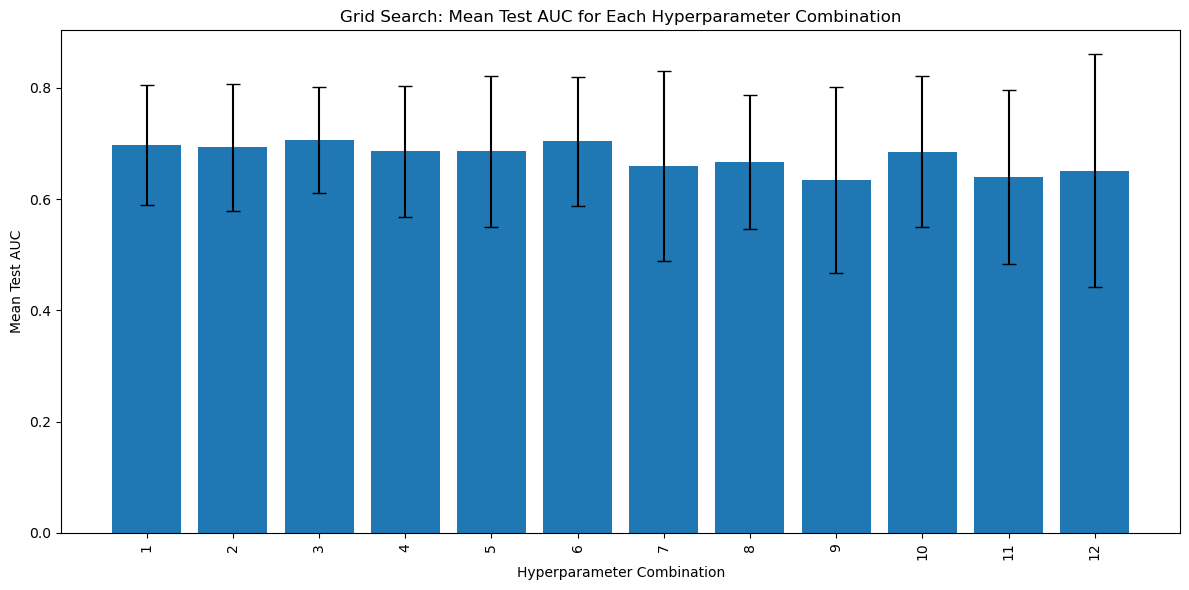

In [ ]:
def main():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    K = 20  
    

    param_grid = {
        'output_dim': [16, 8],
        'dropout': [0.2],
        'batch_size': [8],
        'lr': [0.001, 0.0001],
        'wd': [1e-06, 1e-05, 1e-04],
    }
    
    grid = list(ParameterGrid(param_grid))
    total_combinations = len(grid)
    print(f"Total hyperparameter combinations to evaluate: {total_combinations}")
    

    dataset = load_data("liv")
    X = dataset.data_x
    y = dataset.data_y
    

    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)
    

    all_results = []
    

    for idx, params in enumerate(grid, 1):
        print(f"\n===== Evaluating Hyperparameter Combination {idx}/{total_combinations} =====")
        print(f"Parameters: {params}")
        

        fold_results = []
        
        for fold, (train_indices, test_indices) in enumerate(kf.split(X, y), 1):
            print(f"\n--- Fold {fold}/{K} ---")
            

            sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1)
            train_idx, val_idx = next(sss.split(np.zeros(len(train_indices)), y[train_indices]))
            

            train_subset = Subset(dataset, train_indices[train_idx])
            val_subset = Subset(dataset, train_indices[val_idx])
            test_subset = Subset(dataset, test_indices)
            

            batch_size = params['batch_size']
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=Batch.from_data_list)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=Batch.from_data_list)
            test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=Batch.from_data_list)
            

            model = single_task(
                num_features=75, 
                n_heads1=2, 
                output_dim=params['output_dim'],
                dropout=params['dropout']
            ).to(device)
            

            criterion = FocalLoss(alpha=0.25, gamma=4.0, reduction='mean')
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['wd'])
            

            checkpoint_path = f'/data/home/dbswn0814/2025JCM/model/single task/liv/weight/checkpoint_combination_{idx}_fold_{fold}.pt'
            early_stopping = EarlyStopping(patience=10, verbose=False, path=checkpoint_path, trace_func=lambda x: None)
            

            num_epochs = 1000
            best_epoch = 0
            for epoch in range(1, num_epochs + 1):
                train_loss = train_single_task(epoch, model, criterion, optimizer, device, train_loader)
                val_loss = val_single_task(epoch, model, criterion, device, val_loader)

                early_stopping(val_loss, model)
    
                if early_stopping.early_stop:
                    print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {early_stopping.val_loss_min:.4f}")
                    best_epoch = epoch
                    break
                best_epoch = epoch  
    

            model.load_state_dict(torch.load(checkpoint_path))
            

            test_loss = test_single_task(epoch, model, criterion, device, test_loader)
            test_auc, test_pr_auc, test_accuracy = evaluate_model(model, device, test_loader)
            
            print(f"Fold {fold} Results - Best Epoch: {best_epoch}, Val Loss: {early_stopping.val_loss_min:.4f}, Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}, PR AUC: {test_pr_auc:.4f}, Accuracy: {test_accuracy:.4f}")

            fold_result = {
                'Combination': idx,
                'Fold': fold,
                'Best_Epoch': best_epoch,
                'Best_Val_Loss': early_stopping.val_loss_min,
                'Test_Loss': test_loss,
                'Test_AUC': test_auc,
                'Test_PR_AUC': test_pr_auc,
                'Test_Accuracy': test_accuracy
            }
            fold_results.append(fold_result)
        

        test_losses = [fr['Test_Loss'] for fr in fold_results]
        test_aucs = [fr['Test_AUC'] for fr in fold_results]
        test_pr_aucs = [fr['Test_PR_AUC'] for fr in fold_results]
        test_accuracies = [fr['Test_Accuracy'] for fr in fold_results]
        
        mean_test_loss = np.mean(test_losses)
        std_test_loss = np.std(test_losses)
        mean_test_auc = np.mean(test_aucs)
        std_test_auc = np.std(test_aucs)
        mean_test_pr_auc = np.mean(test_pr_aucs)
        std_test_pr_auc = np.std(test_pr_aucs)
        mean_test_accuracy = np.mean(test_accuracies)
        std_test_accuracy = np.std(test_accuracies)
        

        combination_result = {
            'Combination': idx,
            **params,
            'Mean_Test_Loss': mean_test_loss,
            'Std_Test_Loss': std_test_loss,
            'Mean_Test_AUC': mean_test_auc,
            'Std_Test_AUC': std_test_auc,
            'Mean_Test_PR_AUC': mean_test_pr_auc,
            'Std_Test_PR_AUC': std_test_pr_auc,
            'Mean_Test_Accuracy': mean_test_accuracy,
            'Std_Test_Accuracy': std_test_accuracy
        }
        all_results.append(combination_result)
        

        print(f"\nCombination {idx} Results:")
        print(f"Mean Test Loss: {mean_test_loss:.4f} ± {std_test_loss:.4f}")
        print(f"Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}")
        print(f"Mean Test PR AUC: {mean_test_pr_auc:.4f} ± {std_test_pr_auc:.4f}")
        print(f"Mean Test Accuracy: {mean_test_accuracy:.4f} ± {std_test_accuracy:.4f}")
    

    results_df = pd.DataFrame(all_results)
    results_csv_path = 'single liv grid_search_results.csv'
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nGrid search completed. Results saved to {results_csv_path}")
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(all_results)), results_df['Mean_Test_AUC'], yerr=results_df['Std_Test_AUC'], capsize=5)
    plt.xlabel('Hyperparameter Combination')
    plt.ylabel('Mean Test AUC')
    plt.title('Grid Search: Mean Test AUC for Each Hyperparameter Combination')
    plt.xticks(range(len(all_results)), results_df['Combination'], rotation=90)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()